#### Hartree-Fock in Pytorch

In [235]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np

from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.hartree_fock_library import HFEnergyFunctional
from scipy.sparse import lil_matrix
import torch
import torch.nn as nn
import torch.optim as optim

file_name='data/usdb.nat'


SPS=SingleParticleState(file_name=file_name)

In [142]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [01:02<00:00,  2.59s/it]


In [202]:
nparticles_a=2
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{20}$Ne'

In [214]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))
print('dimension=',NSMHamiltonian.hamiltonian.shape[0])

size= 24 12
[-41.39649007]
total_m= [-6.91856511e-18]
dimension= 640


Hartree-Fock method

In [215]:
model=HFEnergyFunctional(h_vec=torch.tensor(SPS.energies),V_dict=twobody_matrix,num_particles=nparticles_a+nparticles_b)



In [216]:

optimizer = optim.Adam(model.parameters(), lr=0.1)

num_steps = 200
for step in range(num_steps):
    optimizer.zero_grad()
    energy = model()  # calls forward()
    energy.backward()
    optimizer.step()

    if step % 20 == 0 or step == num_steps - 1:
        print(f"Step {step:4d} | Energy = {energy.item():.6f}")

Step    0 | Energy = -14.528265
Step   20 | Energy = -24.684065
Step   40 | Energy = -32.246498
Step   60 | Energy = -36.935009
Step   80 | Energy = -37.143467
Step  100 | Energy = -37.178375
Step  120 | Energy = -37.183258
Step  140 | Energy = -37.183697
Step  160 | Energy = -37.183777
Step  180 | Energy = -37.183777
Step  199 | Energy = -37.183784


In [217]:
def slater_determinants(C, fock_basis):
    # C: [M, N]
    # fock_basis: [F, M]
    F = fock_basis.shape[0]
    N = C.shape[1]
    psi = torch.zeros(F, dtype=C.dtype)

    for i in range(F):
        occ = fock_basis[i]   # [M] boolean
        occ_indices = torch.nonzero(occ).squeeze()              # [N, N] rows of occupied orbitals
        C_sub = C[occ_indices, :]            # [N, N]
        psi[i] = torch.det(C_sub)     # compute Slater determinant amplitude

    return psi  # [F] amplitudes over Fock basis




In [218]:
psi_hf=slater_determinants(model.C,torch.tensor(NSMHamiltonian.basis))
psi_hf=psi_hf.detach().numpy()
print(psi_hf.shape)
psi_hf=psi_hf/np.linalg.norm(psi_hf)



(640,)


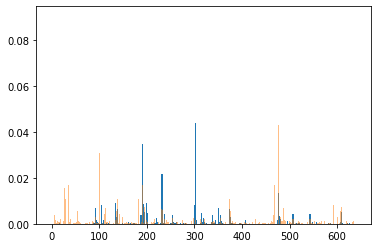

-39.231184539023324
fidelity= 0.2863381713193484


In [219]:
plt.bar(np.arange(psi_hf.shape[0]),psi_hf.conjugate()*psi_hf)
plt.bar(np.arange(psi_hf.shape[0])+0.1,psi0[:,0].conjugate()*psi0[:,0],alpha=0.5)
plt.show()

print(psi_hf.conjugate() @ NSMHamiltonian.hamiltonian @ psi_hf)


print('fidelity=',psi0[:,0].conjugate().dot(psi_hf)*np.conjugate(psi0[:,0].conjugate().dot(psi_hf)))

In [220]:
def check_orthonormal(C, tol=1e-6):
    I = torch.eye(C.shape[1], dtype=C.dtype, device=C.device)
    test = C.T @ C
    return torch.allclose(test, I, atol=tol)

print(check_orthonormal(model.C))

True


#### Sample Based Diagonalization HF and exact Gs

In [221]:
n_instances=9000

In [ ]:
prob_exact=np.conjugate(psi0[:,0])*psi0[:,0]

ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],1)
errors_sdg_gs=[]
energies_sdg_gs=[]
for n_instances in ns_instances: 
        selection=np.random.choice(np.arange(prob_exact.shape[0]),size=n_instances,replace=False,p=prob_exact)
                # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

                # for a,idx_a in enumerate(selection):
                #     for b,idx_b in enumerate(selection):
                #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
                
        effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]


        effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
        errors_sdg_gs.append(np.abs((effective_egs[0]-egs[0])/egs[0]))
        energies_sdg_gs.append(effective_egs[0])
        print(effective_egs)


[-23.29089365]
[-26.47223289]
[-29.68676193]
[-31.08655003]
[-32.0146111]
[-31.59523007]
[-32.77690256]
[-33.16176313]
[-34.83246413]
[-34.25765667]
[-35.09622547]
[-35.35218033]
[-35.88810721]
[-36.23123172]
[-36.24360196]
[-36.61372805]
[-37.30039746]
[-37.28935388]
[-37.61842921]
[-37.75778605]
[-38.30052069]
[-38.41112889]
[-38.50805614]
[-38.66719077]
[-38.72854733]
[-39.3835848]
[-39.43175424]
[-39.37754683]
[-39.73523216]
[-39.95827989]
[-40.02555995]
[-40.02656181]
[-40.20453979]
[-40.30812756]
[-40.41494769]
[-40.39493068]
[-40.59674037]
[-40.70653386]
[-40.77672289]
[-40.83399605]
[-40.81396718]
[-40.92932566]
[-41.03540487]
[-41.08677517]
[-41.07953023]
[-41.11978288]
[-41.16888786]
[-41.21503702]
[-41.19392725]
[-41.27272663]
[-41.29760989]
[-41.30970927]
[-41.34017673]
[-41.35183329]
[-41.35681152]
[-41.37041039]
[-41.37728961]
[-41.38443891]
[-41.39341433]
[-41.39562385]
[-41.396386]
[-41.39649007]
[-41.39649007]
[-41.39649007]


In [238]:
prob_hf=np.conjugate(psi_hf[:])*psi_hf[:]

#ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],20)
errors_sdg_hf=[]
energies_sdg_hf=[]
fidelities=[]
ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],1)


for n_instances in ns_instances: 
        selection=np.random.choice(np.arange(prob_hf.shape[0]),size=n_instances,replace=False,p=prob_hf)
                # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

                # for a,idx_a in enumerate(selection):
                #     for b,idx_b in enumerate(selection):
                #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
                
        effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
        psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])
        

        effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
        psi_selected[selection]=effective_psi0[:,0]
        fidelities.append(1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0])))
        errors_sdg_hf.append(np.abs((effective_egs[0]-egs[0])/egs[0]))
        energies_sdg_hf.append(effective_egs[0])
        print(effective_egs)


[-29.21857715]
[-24.50403486]
[-25.2824266]
[-25.31780347]
[-29.33175434]
[-29.70158228]
[-29.40895637]
[-29.83238405]
[-29.59865583]
[-27.18427508]
[-29.59919838]
[-30.27399992]
[-29.92540726]
[-30.78291895]
[-31.17830125]
[-29.54274492]
[-30.2857586]
[-29.51578947]
[-30.61114455]
[-32.06204718]
[-31.51505939]
[-29.46693024]
[-31.73792449]
[-30.39096758]
[-32.4102725]
[-31.57467741]
[-31.34081703]
[-32.40437281]
[-32.30349414]
[-32.58021664]
[-32.3714109]
[-32.78978594]
[-33.70633035]
[-32.21775137]
[-33.15529967]
[-31.30825868]
[-33.40652331]
[-32.59377299]
[-32.0684079]
[-33.69227877]
[-33.46323337]
[-32.94035478]
[-33.55304047]
[-33.14730363]
[-33.7567593]
[-33.68809138]
[-33.47864599]
[-33.97756455]
[-33.84633725]
[-33.92024756]
[-33.83359855]
[-34.28836313]
[-34.18111122]
[-34.8622019]
[-34.32627293]
[-33.81984966]
[-34.25151561]
[-33.99067471]
[-34.53942732]
[-34.67653765]
[-34.29429737]
[-34.45431879]
[-34.73641462]
[-35.14394634]
[-35.29029483]
[-34.83280968]
[-34.80689678]
[-

In [ ]:
prob_hf=np.conjugate(psi_hf[:])*psi_hf[:]

#ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],20)
errors_sdg_hf=[]
energies_sdg_hf=[]
fidelities=[]
max_iterations=100
prob_sampler=prob_hf.copy()
ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],1)
selection=np.random.choice(np.arange(prob_hf.shape[0]),size=2,replace=False,p=prob_hf)
selected_samples=[selection[0],selection[1]]
effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])

prob_sampler[selected_samples]=0

effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
e_old=effective_egs.copy()

for r in range(NSMHamiltonian.hamiltonian.shape[0]-2): 
    
    for i in range(max_iterations):
        selection=np.random.choice(np.arange(prob_hf.shape[0]),size=1,replace=False,p=prob_sampler)
        tentative_selection=selected_samples+[selection[0]]
        
        effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[tentative_selection,:][:,tentative_selection]
        psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])
        effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
        psi_selected[selection]=effective_psi0[:,0]
        fidelities.append(1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0])))
        errors_sdg_hf.append(np.abs((effective_egs[0]-egs[0])/egs[0]))
        energies_sdg_hf.append(effective_egs[0])
        print(effective_egs)
    
    

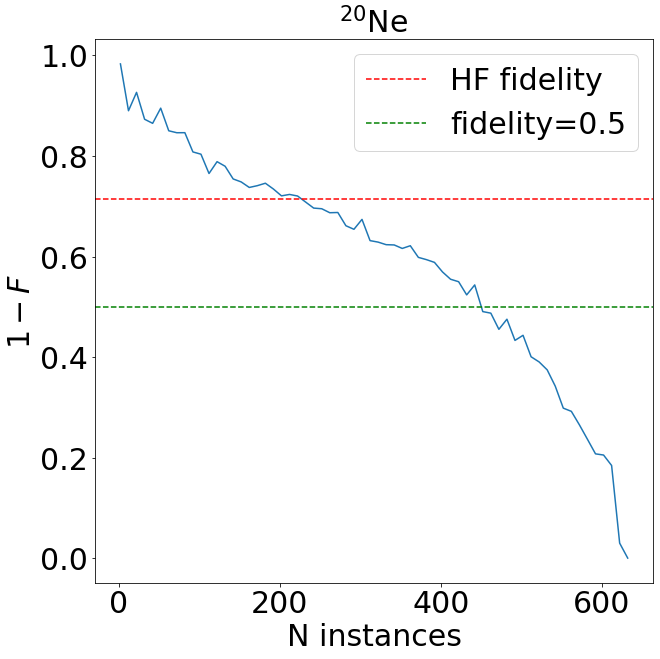

In [234]:
plt.figure(figsize=(10,10))
plt.plot(ns_instances,fidelities)
plt.axhline(y=1-psi0[:,0].conjugate().dot(psi_hf)*np.conjugate(psi0[:,0].conjugate().dot(psi_hf)),label='HF fidelity',color='red',linestyle='--')
plt.axhline(y=0.5,label='fidelity=0.5',color='green',linestyle='--')
plt.tick_params(labelsize=30)
plt.xlabel('N instances',fontsize=30)
plt.ylabel(r'$1-F$',fontsize=30)
plt.title(title,fontsize=30)
plt.legend(fontsize=30)
plt.show()

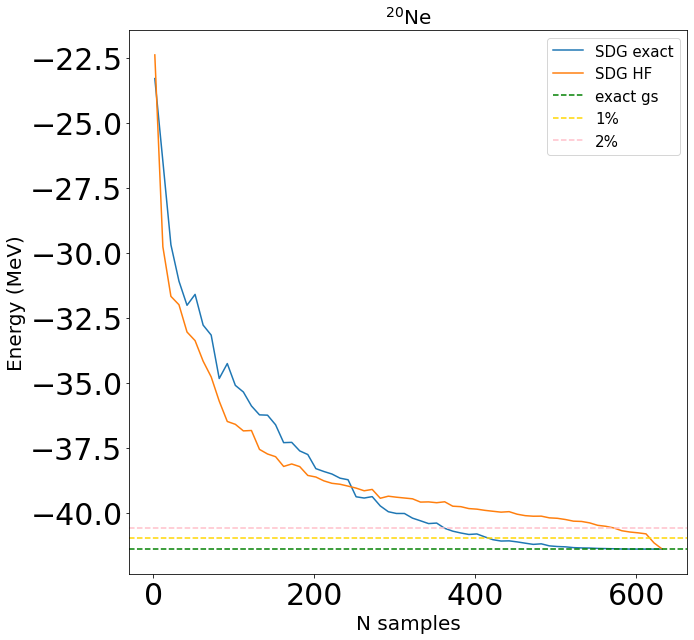

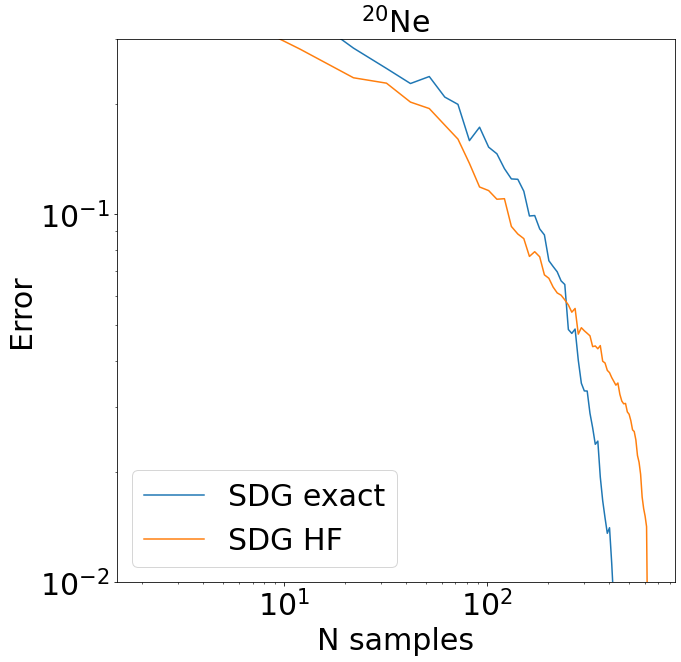

In [224]:
plt.figure(figsize=(10,10))
plt.plot(ns_instances,energies_sdg_gs,label='SDG exact')
plt.plot(ns_instances,energies_sdg_hf,label='SDG HF')
#plt.axhline(y=model().detach().numpy(),color='red',linestyle='--',label='HF')
plt.axhline(y=egs[0],color='green',linestyle='--',label='exact gs')
plt.axhline(y=egs[0]*(0.99),color='gold',linestyle='--',label='1%')
plt.axhline(y=egs[0]*(0.98),color='pink',linestyle='--',label='2%')
plt.xlabel('N samples',fontsize=20)
plt.ylabel('Energy (MeV)',fontsize=20)
plt.legend(fontsize=15)
plt.title(title,fontsize=20)
plt.tick_params(labelsize=30)
plt.show()

energies_sdg_hf=np.asarray(energies_sdg_hf)
energies_sdg_gs=np.asarray(energies_sdg_gs)


plt.figure(figsize=(10,10))
plt.plot(ns_instances,np.abs((energies_sdg_gs-egs[0])/egs[0]),label='SDG exact')
plt.plot(ns_instances,np.abs((energies_sdg_hf-egs[0])/egs[0]),label='SDG HF')
plt.xlabel('N samples',fontsize=30)
plt.ylabel('Error',fontsize=30)
plt.tick_params(labelsize=30)
plt.ylim([10**-2,0.3])

plt.title(title,fontsize=30)
plt.loglog()
plt.legend(fontsize=30)
plt.show()